# _Fourier non-Gaussianity_

## Check the empirical PDF of Fourier modes of an isotropic non-Gaussian field

It seems to be the case that even for highly non-Gaussian fields, the 1PDF is "very" Gaussian.
(Perhaps slightly non-Gaussian for low $kL$?)

Currently only have local non-Gaussianity $f(x) = F(g(x))$ where $g(x)$ is an isotropic Gaussian.


### TODO

* can we reverse engineer a non-Gaussian PDF? 
* Start with anisotropic field?
* Can we actually see this from Matsubara's formulae?


In [1]:
from __future__ import print_function

import joblib
from ipyparallel import Client, require
rc = Client()
dview = rc[:]

import numpy as np
import matplotlib.pyplot as plt
import realization as rn
import numpy as np

with dview.sync_imports():
    ### unfortunately these don't get good "short names"
    import realization
    import numpy
%px np = numpy; rn = realization

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

importing realization on engine(s)
importing numpy on engine(s)


In [22]:
size = 2048
ndims = 2

nMC = 18
excise = None  # 2 1

def trans(g):
#    h = 1./(10.+g)
    h = np.exp(g)
    return h-np.mean(h)

dims = (size,)*ndims


### serial:
#kout, stats, hists = rn.ng.driver(dims=(1024,1024), fNL=1, Pk=-1, eq_vol=True, ng_pow=-1, fG=0.0)
# stats_all = []
# for _ in range(nMC):
#     kout, stats, hists = rn.ng.driver(dims=(2048,2048), fNL=1, Pk=-0.5, eq_vol=False, transform=trans)
#     stats_all.append(stats)

### several possible parallel models

dview.push(dict(dims=dims, excise=excise, trans=trans))

### ipyparallel with scatter/gather
# dview.scatter('iMC', range(nMC))
# %px ar = [rn.ng.driver(dims=dims, fNL=0, Pk=-1, eq_vol=False, transform=trans, excise=excise) for _ in iMC ]
# all_results = dview.gather('ar')

### ipyparallel map:

#... sometimes getting weird UnicodeDecodeError using ipyparallel -- need to run jupyter under python2? 
#    Seems to work now...
all_results = dview.map_sync(
        lambda _: rn.ng.driver(dims=dims, fNL=1.0, Pk=-1.0, eq_vol=False, transform=None, excise=excise),
        range(nMC)
)

# # or use joblib (not in stdlib!) instead...
# def wrapper(_):
#     return realization.ng.driver(dims=dims, fNL=0, Pk=-1, eq_vol=False, transform=None, excise=excise)

# # all_results = joblib.Parallel(n_jobs=3)(joblib.delayed(wrapper)(i) for i in range(nMC))

stats_all = np.array([a[1] for a in all_results])
kout = np.array(all_results[0][0])
hists = np.array(all_results[0][2])   ## or could  collect all hists and do mean?

In [23]:
stats_all = np.array(stats_all)
stats_mean = stats_all.mean(axis=0)
stats_std = stats_all.std(axis=0) if nMC>1 else None

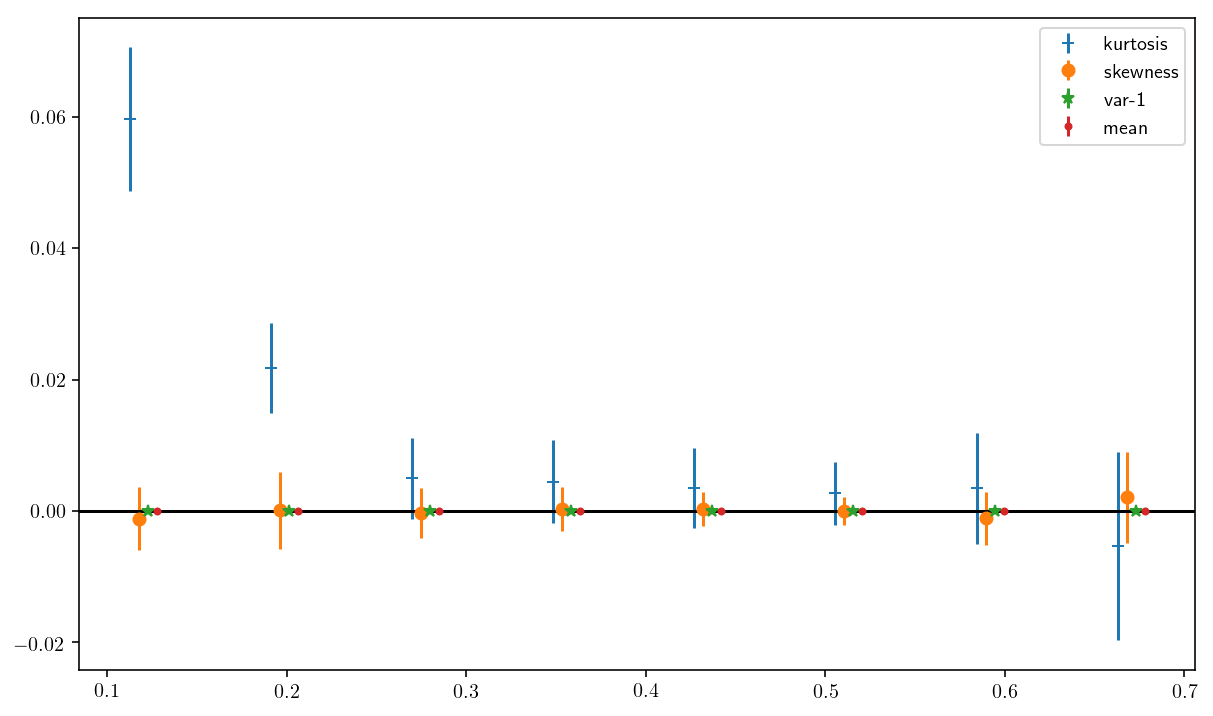

In [24]:
plt.figure()
i1 = 1

if stats_std is None:
    plt.plot(kout[i1:], stats_mean.T[3][i1:], '+', label='kurtosis');
    plt.plot(kout[i1:], stats_mean.T[2][i1:], 'o', label='skewness');
    plt.plot(kout[i1:], stats_mean.T[1][i1:]-1, '*', label='var-1');
    plt.plot(kout[i1:], stats_mean.T[0][i1:], '.', label='mean');
else:
    plt.errorbar(kout[i1:]-0.005, stats_mean.T[3][i1:],   yerr=stats_std.T[3][i1:], fmt='+', label='kurtosis');
    plt.errorbar(kout[i1:]+0.000, stats_mean.T[2][i1:],   yerr=stats_std.T[2][i1:], fmt='o', label='skewness');
    plt.errorbar(kout[i1:]+0.005, stats_mean.T[1][i1:]-1, yerr=stats_std.T[1][i1:], fmt='*', label='var-1');
    plt.errorbar(kout[i1:]+0.010, stats_mean.T[0][i1:],   yerr=stats_std.T[0][i1:], fmt='.', label='mean');

    plt.axhline(y=0, color='k')

plt.legend()


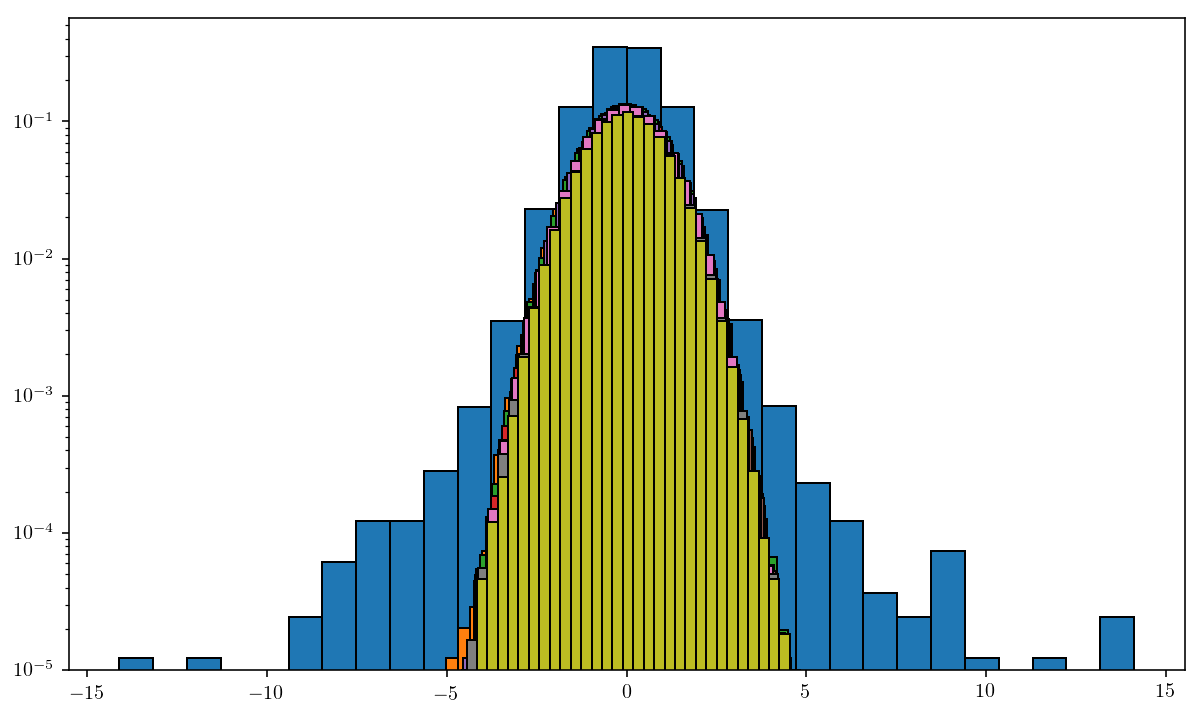

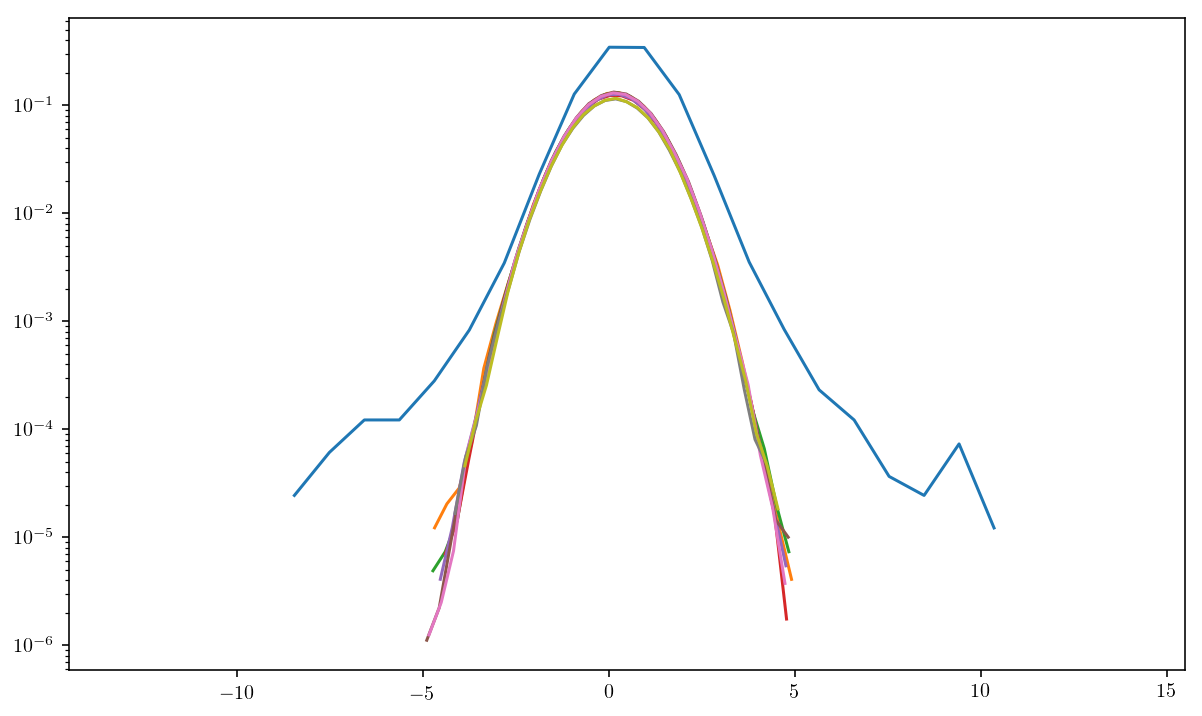

In [25]:
## see http://stackoverflow.com/questions/44003552/matplotlib-histogram-from-numpy-histogram-output
for frq, edges in hists[0:]:
    frq = np.array(frq,dtype=np.float)
    frq /= frq.sum()
    plt.bar(edges[:-1], frq, width=np.diff(edges), ec="k", align="edge", log=True)
    # plt.figure()
    
plt.figure()
for frq, edges in hists[0:]:
    frq = np.array(frq,dtype=np.float)
    frq /= frq.sum()
    ctrs = edges[:-1] + np.diff(edges)
    plt.semilogy(ctrs, frq)
    # plt.figure()

In [ ]:
rlzn_fourier0, rlzn_config0 = rn.ng.local_fNL((4096,4096), 1, -2, return_config=True, ng_pow=-1, fG=0)
rlzn_fourier100, rlzn_config100 = rn.ng.local_fNL((4096,4096), 1, -2, return_config=True, ng_pow=2)

In [ ]:
plt.imshow(rlzn_config0); plt.axis("scaled"); plt.colorbar()
plt.figure()
plt.imshow(rlzn_config100); plt.axis("scaled"); plt.colorbar()

In [ ]:
plt.imshow(np.log(np.abs(rlzn_fourier0[:rlzn_fourier0.shape[0]/2])/4096),vmin=-5,vmax=7, origin='lower'); plt.colorbar(); plt.axis("scaled")
plt.figure()
plt.imshow(np.log(np.abs(rlzn_fourier100[:rlzn_fourier100.shape[0]/2])/4096), vmin=10,vmax=17, origin='lower'); plt.colorbar(); plt.axis("scaled")

In [ ]:
_=plt.hist(np.log(np.abs(rlzn_fourier100)/4096).ravel(), bins=50)

In [ ]:
plt.imshow?

In [ ]:
rlzn_fourier0[:rlzn_fourier.shape[0]/2].shape

In [ ]:
q(3)

In [ ]:
dview.